In [10]:
using CSV
using JuMP, Ipopt
using MosekTools 
using Gurobi
using DataFrames #, IndexedTables
using CSV
using LinearAlgebra
using Plots#, PlotlyJS
using Statistics

In [11]:
df = DataFrame(CSV.File("baseline_all.csv"));
first(df, 2)

Row,Column1,year,amt,cma,sma,p_cma,p_sma,balance_cma,balance_sma,state
,Int64,Int64,Float64,Float64,Float64?,Float64?,Float64?,Float64?,Float64?,String
1,0,1975,17954.0,17954.0,missing,missing,missing,missing,missing,MD
2,1,1976,0.0,8977.0,missing,17954.0,missing,0.0,missing,MD


In [12]:
#number of states
N = length(unique(df.state)); 
#number of years 
T = length(unique(df.year)); 

state_list = unique(df.state);
time_list = unique(df.year);
print(state_list[50])

AK

In [13]:
#amount matrix
M_amt = Matrix{Float64}(undef,N,T); 

#construct M_amt: where i, t = loss at state i in time t 
df[df.state .== "LA", "amt"] 

i=1
for state in state_list
    M_amt[i,:] = df[df.state .== state, "amt"] 
    i+=1 
end 

In [14]:
#construct premium baseline 
#baseline premium for final 10 years 
P_base = Matrix{Float64}(undef,N,10); 

#construct P_base: where i, t = premium using CMA at state i in time t 
i=1
for state in state_list
    P_base[i,:] = df[df.state .== state, "p_cma"][end-9:end] #final 10 years of premium 
    i+=1 
end 

In [15]:
#load risk matrix 
risk = DataFrame(CSV.File("risk.csv"))
#get loss list based on column names except for the first column (state name)
loss_list = names(risk)[2:end]
#convert string items to integer 
loss_list = parse.(Float64,loss_list)

#risk matrix 
R = Matrix{Float64}(undef,N,length(loss_list)); 

#iterate over the same state_list to make sure i corresponds to the same state 
i=1 
for state in state_list
    R[i,:] = Array(risk[risk.Column1.==state, 2:end]); 
    i+=1 
end 

#NOTE: this R is calculated using last 10y of data, maybe "cheating" a little 

In [16]:
loss_list[1]*R[1,1]

48843.85416666667

In [17]:
model = Model(Gurobi.Optimizer)
set_optimizer_attribute(model, "TimeLimit", 30)

# VARIABLES: premium for the next 10 years 
@variable(model, P[1:N,1:T] >=0);  #P_i,t is the premium at state i in time t 

# each state premium covers risk*loss levels, iterate over i=state, j=loss levels  
@constraint(model, test_constraint[i=1:N, j=1:4],
    sum(P[i, t] for t = 1:T) >= loss_list[j]*R[j,1]); 

#slowly vary 
gamma1 = 50000  
@constraint(model, slowly_vary[i=1:N, t=2:T],
    P[i,t] - P[i, t-1] <= gamma1);

@objective(
        model, Min, sum(P[i, t] for i=1:N, t=1:T)
    )

optimize!(model)
    

Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2703 rows, 2544 columns and 15158 nonzeros
Model fingerprint: 0xa163fbf9
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+04, 3e+08]
Presolve removed 159 rows and 0 columns
Presolve time: 0.00s
Presolved: 2544 rows, 2544 columns, 7526 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.498418e+07   0.000000e+00      0s
       7    1.4833294e+10   0.000000e+00   0.000000e+00      0s

Use crossover to convert LP symmetric solution to basic solution...
Crossover log...

    2173 PPushes remaining with PInf 0.0000000e+00                 0s
       0 PPushes remaining with PInf 0.0000000e+00                 0s

  Push phase c

In [18]:
value.(P);

In [19]:
#attempt 2: calculate the risk level for each state 
quantile!(M_amt[1,:], 0.5)

q_list = [0.25, 0.5, 0.75, 0.99]
#loss matrix, where L_i,j is loss level for state i at quantile q
L = Matrix{Float64}(undef,N,length(q_list)); 

#iterate over the same state_list to make sure i corresponds to the same state 
i = 1 
for state in state_list
    j=1
    for q in q_list 
        L[i,j] = quantile!(M_amt[i,:], q); 
        j+=1 
    end
    i+=1
end 

#

In [20]:
L_matrix = DataFrame(L, [:"0.25",:"0.5",:"0.75",:"0.99"])
L_matrix[!, "state"]= state_list; 
L_matrix

Row,0.25,0.5,0.75,0.99,state
,Float64,Float64,Float64,Float64,String
1,1.09381e5,6.10262e5,3.85072e6,8.46682e7,MD
2,4204.16,28194.3,95595.7,3.13565e6,MT
3,7.78916e6,4.00858e7,1.05799e8,4.56488e9,TX
4,2.77073e6,1.72262e7,8.4247e7,9.57895e8,FL
5,2.97197e5,1.06268e6,3.12877e6,2.36586e8,SC
6,5.49437e5,2.06047e6,1.14584e7,1.46471e8,VA
7,2.06109e5,5.46128e5,1.98335e6,2.71614e7,MI
8,1.03582e6,6.77015e6,1.84009e7,3.91003e8,NC
9,1.45869e6,3.69406e6,1.8174e7,2.20647e9,NJ


In [21]:
model2 = Model(Gurobi.Optimizer)
set_optimizer_attribute(model2, "TimeLimit", 30)

# VARIABLES: premium for the next 10 years 
T1 = 10 
@variable(model2, P[1:N,1:T1] >=0);  #P_i,t is the premium at state i in time t 

# each state premium covers risk*loss levels, iterate over i=state, j=loss levels  
@constraint(model2, test_constraint[i=1:N, j=1:4],
    sum(P[i, t] for t = 1:T1) >= L[i,j]*(1-q_list[j])); 

#slowly vary 
gamma1 = 50000  
@constraint(model2, slowly_vary[i=1:N, t=2:T1],
    P[i,t] - P[i, t-1] <= gamma1);
@constraint(model2, slowly_vary2[i=1:N, t=2:T1],
    P[i,t-1] - P[i, t] <= gamma1)

@objective(
        model2, Min, sum(P[i, t] for i=1:N, t=1:T1)
    )

optimize!(model2)

P_lp = value.(P); 

Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1166 rows, 530 columns and 4028 nonzeros
Model fingerprint: 0x48daa975
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+01, 7e+07]
Presolve removed 636 rows and 0 columns
Presolve time: 0.00s
Presolved: 530 rows, 1007 columns, 1961 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.368122e+08   0.000000e+00      0s
     325    2.3681219e+08   0.000000e+00   0.000000e+00      0s

Solved in 325 iterations and 0.00 seconds
Optimal objective  2.368121859e+08

User-callback calls 356, time in user-callback 0.00 sec


In [22]:
#compute some performance
#actual loss 
act_loss = M_amt[:,end-9:end]; 


In [23]:
using Plots

SC

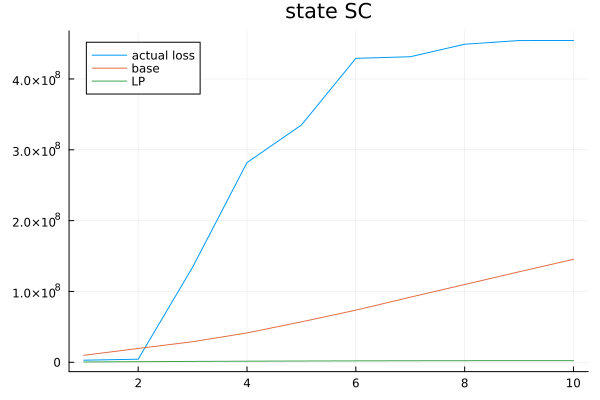

In [24]:
x = range(1, 10)
i = 5
print(state_list[i])
act = cumsum(act_loss[i,:])
base = cumsum(P_base[i,:])
LP= cumsum(P_lp[i,:])
plot(x, [act,  base, LP], label=["actual loss" "base" "LP"], title="state $(state_list[i])")

In [25]:
state_list;

In [26]:
#compute the cumsum from LP - act for each state 
c1= sum(P_lp, dims=2)-sum(act_loss, dims=2)  
c2 = sum(P_base, dims=2)-sum(act_loss, dims=2)  

df1 = DataFrame(hcat(c1, c2), [:"LP",:"Base"])

df1[!,"state"] = state_list.clone()
select!(df1, :"state",:)

# top 10 states running deficit according to LP 
# deficit = first(df1, 15)
# bar(deficit.state, deficit.LP, title="top 15 deficit states")


# top 10 states running deficit according to LP 
sort!(df1,[:"LP"], rev=true)
surplus = first(df1, 15)
# bar(surplus.state, surplus.LP, title="top 15 surplus states")

LoadError: type Array has no field clone

In [27]:
#compute cumulative loss of Premium - loss for the last 10 years 
println(sum(P_base)-sum(act_loss))
println(sum(P_lp)-sum(act_loss))
println(sum(P_lp)-sum(P_base))


-8.305897219413555e9
-1.967520451280916e10
-1.1369307293395605e10


In [28]:
#approach 3: min max approach 


In [29]:
#inner problem: 
#for each state compute the variance 


In [30]:
size(M_amt)

(53, 48)

In [31]:
#compute the historical mean and variance up to 10 years  
M_hist = M_amt[:, 1:end-10]; 
std_hist = std(M_hist, dims=2); 
mean_hist = mean(M_hist, dims=2); 

#
gamma2 = 1 

#compute $L^*_i$ for each i, where
$
L^* := \sum_{t=T0}^{t=T1} l^*_{i,t}
$\
where 
$
\sum_{t=T0}^{t=T1} l^*_{i,t} = \bar{l}_i (T1-T0) + \gamma_2 \sigma_i \sqrt(T1-T0) 
$

In [32]:
gamma2 = 0.8
L_star = 10*mean_hist + gamma2*std_hist*sqrt(10); 

model3 = Model(Gurobi.Optimizer)
set_optimizer_attribute(model3, "TimeLimit", 30)

# VARIABLES: premium for the next 10 years 
T1 = 10 
@variable(model3, P[1:N,1:T1] >=0);  #P_i,t is the premium at state i in time t 

surplus = 5000 

# each state premium covers state loss L* from the inner problem 
@constraint(model3, test_constraint[i=1:N],
    sum(P[i, t] for t = 1:T1) - L_star[i] >= surplus); 

#slowly vary 
gamma1 = 50000  
@constraint(model3, slowly_vary[i=1:N, t=2:T1],
    P[i,t] - P[i, t-1] <= gamma1);
@constraint(model3, slowly_vary2[i=1:N, t=2:T1],
    P[i,t-1] - P[i, t] <= gamma1)

@objective(
        model3, Min, surplus 
    )

optimize!(model3)
P_ro = value.(P);   

Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1007 rows, 530 columns and 2438 nonzeros
Model fingerprint: 0x5e546ac0
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+04, 8e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 583 rows and 106 columns
Presolve time: 0.00s
Presolved: 424 rows, 689 columns, 1431 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.0000000e+03   2.712527e+09   0.000000e+00      0s
     315    5.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 315 iterations and 0.00 seconds
Optimal objective  5.000000000e+03

User-callback calls 356, time in user-callback 0.00 sec


In [33]:
#compute some performance
#actual loss 
act_loss = M_amt[:,end-9:end]; 


In [34]:
using Plots

In [35]:
state_list[50]

"AK"

ME

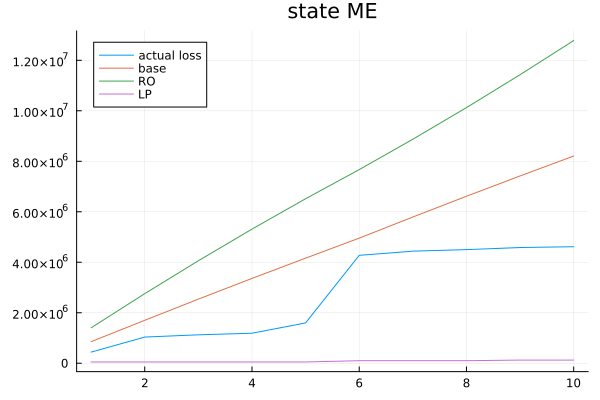

In [36]:
x = range(1, 10)
i = 49
print(state_list[i])
act = cumsum(act_loss[i,:])
base = cumsum(P_base[i,:])
RO= cumsum(P_ro[i,:])
LP = cumsum(P_lp[i,:])
plot(x, [act,  base, RO, LP], label=["actual loss" "base" "RO" "LP"], title="state $(state_list[i])")

In [37]:
#compute the cumsum from RO - act for each state 
c1= sum(P_lp, dims=2)-sum(act_loss, dims=2)  
c2 = sum(P_base, dims=2)-sum(act_loss, dims=2)  
c3= sum(P_ro, dims=2)-sum(act_loss, dims=2)  

df1 = DataFrame(hcat(c1, c2, c3), [:"LP",:"Base",:"RO"])

df1[!,"state"] = state_list
select!(df1, :"state",:)

##top 10 states running deficit according to LP 
# sort!(df1,[:"RO"], rev=false)
# deficit = first(df1, 15)
# #bar(deficit.state, deficit.LP, title="top 15 deficit states")


# top 10 states running deficit according to LP 
sort!(df1,[:"RO"], rev=true)
surplus = first(df1, 15)
# bar(surplus.state, surplus.LP, title="top 15 surplus states")

Row,state,LP,Base,RO
,String,Float64,Float64,Float64
1,LA,-3.72152e9,-3.66873e8,4.01878e9
2,NY,-2.27566e8,8.63445e8,2.4994e9
3,NJ,-4.38932e8,7.26014e8,2.35778e9
4,MS,-1.24497e8,4.11052e8,1.2501e9
5,CT,-4.24985e7,5.95984e7,1.71721e8
6,AL,-2.41319e8,-4.49769e7,1.18011e8
7,ND,-2.09581e6,5.27349e7,1.08682e8
8,PA,-2.70885e8,-5.16526e7,9.94224e7
9,VA,-1.23478e8,7.49386e6,9.42501e7


In [38]:
#compute cumulative loss of Premium - loss for the last 10 years 
println(sum(P_base)-sum(act_loss))
println(sum(P_ro)-sum(act_loss))
println(sum(P_lp)-sum(act_loss))


-8.305897219413555e9
1.8040972815770874e9
-1.967520451280916e10


In [39]:
#try different gammas 
gamma2 = 0.8

function solve_RO(gamma2)
    
        #gamma determines L_star
        L_star = 10*mean_hist + gamma2*std_hist*sqrt(10); 

        model3 = Model(Gurobi.Optimizer)
        set_optimizer_attribute(model3, "TimeLimit", 30)

        # VARIABLES: premium for the next 10 years 
        T1 = 10 
        @variable(model3, P[1:N,1:T1] >=0);  #P_i,t is the premium at state i in time t 

        surplus = 5000 

        # each state premium covers state loss L* from the inner problem 
        @constraint(model3, test_constraint[i=1:N],
            sum(P[i, t] for t = 1:T1) - L_star[i] >= surplus); 

        #slowly vary 
        gamma1 = 50000  
        @constraint(model3, slowly_vary[i=1:N, t=2:T1],
            P[i,t] - P[i, t-1] <= gamma1);
        @constraint(model3, slowly_vary2[i=1:N, t=2:T1],
            P[i,t-1] - P[i, t] <= gamma1)

        @objective(
                model3, Min, surplus 
            )

        optimize!(model3)
        P_ro = value.(P);   
    return P_ro 
end 

solve_RO (generic function with 1 method)

In [40]:
gamma2_ls = [0.2,0.4,0.6,0.8,1,1.2,1.4]
surplus_ls = Array{Float64}(undef,length(gamma2_ls));

i=1 
for gamma2 in gamma2_ls
    P_ro = solve_RO(gamma2); 
    s = sum(P_ro)-sum(act_loss)
    surplus_ls[i] = s 
    i+=1 
end  

Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1007 rows, 530 columns and 2438 nonzeros
Model fingerprint: 0xfdda6775
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+04, 4e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 583 rows and 106 columns
Presolve time: 0.00s
Presolved: 424 rows, 689 columns, 1431 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.0000000e+03   1.674556e+09   0.000000e+00      0s
     311    5.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 311 iterations and 0.00 seconds
Optimal objective  5.000000000e+03

User-callback calls 352, time in user-callback 0.00 sec
A

In [41]:
DataFrame(hcat(gamma2_ls, surplus_ls), [:"Gamma2",:"Surplus"])


Row,Gamma2,Surplus
,Float64,Float64
1,0.2,-6.49967e9
2,0.4,-3.73175e9
3,0.6,-9.63824e8
4,0.8,1.8041e9
5,1.0,4.57202e9
6,1.2,7.33994e9
7,1.4,1.01079e10


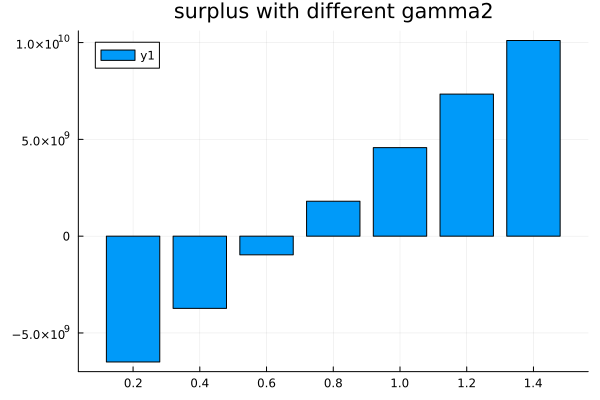

In [42]:
#plot different gamma2 leading to different surplus 
bar(gamma2_ls , surplus_ls, title="surplus with different gamma2")

In [43]:
# Approach 4 RO + demand decline 

l_max= 1.079988857742e10


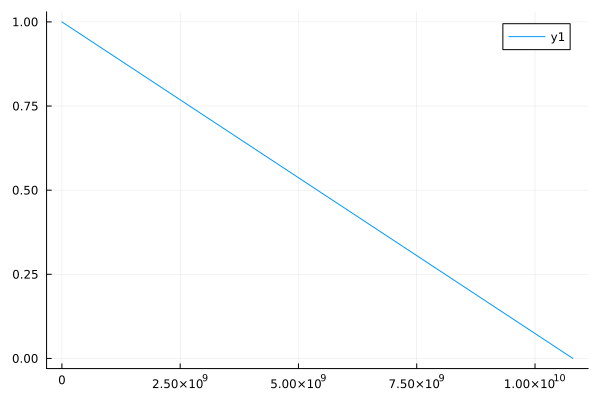

In [45]:
## Attempt 1: linearly decline 
#l_max is the largest historical flood amount overall states overall years 
l_max = maximum(M_hist)
#rate is 1/l_max 
println("l_max= ", l_max)


function f_linear(p, slope = 1/l_max) #default rate is 1/P_max 
    f = 1 - slope*p 
    
#     #set floor to zero: #this constraint is giving me problems 
#     if f<0
#         f=0 
#     end 
    
    return f
end 

f_linear(1)
plot(f_linear, 0, l_max)

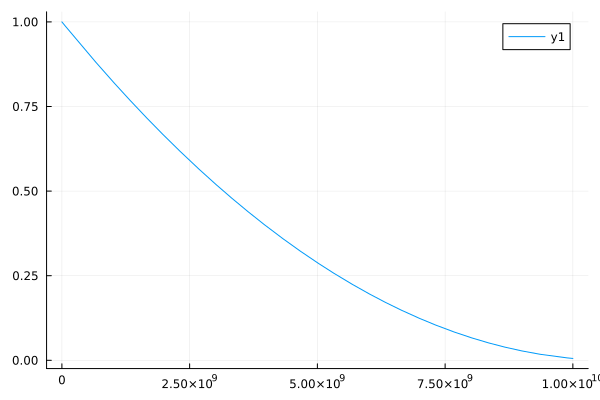

In [46]:
function f_quadratic(p, P_lim = l_max)
    k = P_lim^2
    f_p = 1/k*(p-P_lim)^2
    return f_p 
end 

f_quadratic(1, l_max)

plot(f_quadratic, 0, 1e10)

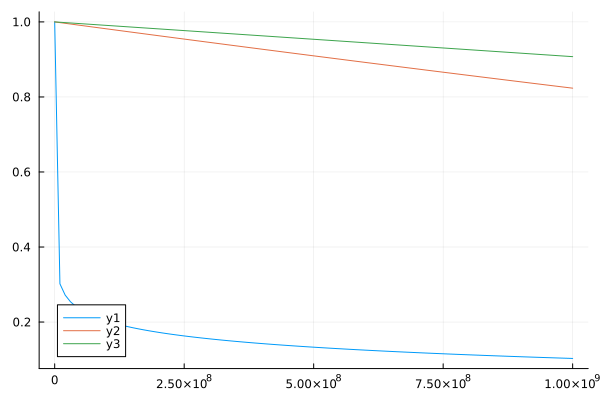

In [47]:
function f_log(p, P_lim = l_max)
    
    k = log(P_lim)
    f_p = 1-log(p+1)*1/k
    return f_p 
end 

x = range(0, 1e9, length=100)
plot(x, [f_log, f_quadratic, f_linear])

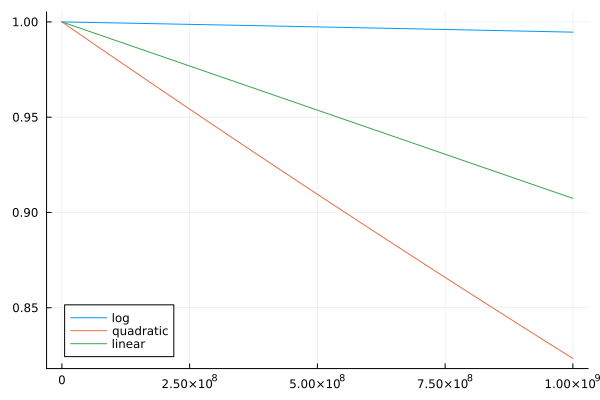

In [48]:
function f_log2(p, P_lim = 0.8*l_max)
    
    k = log(P_lim)
    f_p = log(-p+P_lim)*1/k
    return f_p 
end 

x = range(0, 1e9, length=100)
plot(x, [f_log2, f_quadratic, f_linear], label=["log" "quadratic" "linear"])
# plot(x, f_log2)

In [49]:
#try different gammas 
gamma2 = 0.8
P_lim = l_max #historical max 

    
#gamma determines L_star
L_star = 10*mean_hist + gamma2*std_hist*sqrt(10); 
println("L_star", maximum(L_star))

#         model3 = Model(Gurobi.Optimizer)
model3 = Model(Ipopt.Optimizer)
#         model3 = Model(Mosek.Optimizer)
set_attribute(model3, "max_cpu_time", 60.0)
#         set_optimizer_attribute(model3, "TimeLimit", 30)
register(model3, :f_linear, 2, f_linear; autodiff = true)

# VARIABLES: premium for the next 10 years 
T1 = 10 
@variable(model3, P[1:N,1:T1] >=0);  #P_i,t is the premium at state i in time t 

surplus = 1000 

# each state premium covers state loss L* from the inner problem 
# adding demand term to demp the revenue: reduce demand by f(P), reduce loss by avg of f(P) across time 
my_slope=1/P_lim 

@NLconstraint(model3, coverage[i=1:N],
    sum(P[i, t]* f_linear(P[i,t], my_slope) for t = 1:T1) - L_star[i]*1/T1*sum(f_linear(P[i,t], my_slope) for t = 1:T1) >= surplus); 

# #simpler constraint, without considering 
# @NLconstraint(model3, coverage[i=1:N],
#     sum(P[i, t]* f_log2(P[i,t]) for t = 1:T1) - L_star[i]  >= surplus); 


@constraint(model3, set_limit[i=1:N, t=1:T1],
    P[i,t] <= 2*P_lim )

#slowly vary 
gamma1 = 50000  
@constraint(model3, slowly_vary[i=1:N, t=2:T1],
    P[i,t] - P[i, t-1] <= gamma1);
@constraint(model3, slowly_vary2[i=1:N, t=2:T1],
    P[i,t-1] - P[i, t] <= gamma1)

@objective(
        model3, Min, surplus 
    )

optimize!(model3)
P_ro = value.(P);   


L_star7.808811639581051e9

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     2968
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      530
                     variables with only lower bounds:      530
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Tot

In [51]:
# P_ro2 = solve_RO2(gamma2)
println(maximum(P_ro))
println(minimum(P_ro))

7.808812847103283e8
2.599723570994909e6


In [52]:
println(maximum(L_star))
println(minimum(L_star))

7.808811639581051e9
602707.2778836392


In [53]:
#compute cumulative loss of Premium - loss for the last 10 years 
println(sum(P_base)-sum(act_loss))
println(sum(P_ro)-sum(act_loss))


-8.305897219413555e9
2.1116805892713394e9


MS

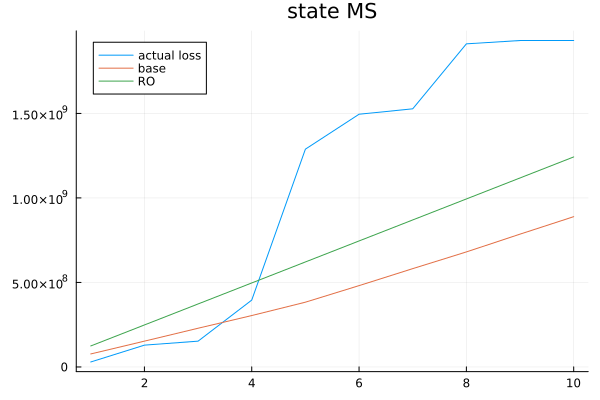

In [54]:
x = range(1, 10)
i = 4
print(state_list[i])
act = cumsum(act_loss[i,:])
base = cumsum(P_base[i,:])
RO= cumsum(P_ro[i,:])
# LP = cumsum(P_lp[i,:])
plot(x, [act,  base, RO], label=["actual loss" "base" "RO"], title="state $(state_list[i])")

In [104]:
RO

10-element Vector{Float64}:
 1.2425556115235868e8
 2.4851112230471706e8
 3.7276668345707536e8
 4.970222446094332e8
 6.212778057617917e8
 7.455333669141515e8
 8.697889280665103e8
 9.940444892188685e8
 1.1183000503712273e9
 1.242555611523588e9

In [105]:
#load actual policy premiums 

df_policy = DataFrame(CSV.File("nfip_premium_agg.csv"));
first(df_policy, 2)

Row,propertyState,year,sum,count,mean
,String,Int64,Float64,Int64,Float64
1,AK,2010,2628.0,4,657.0
2,AK,2011,3127.0,4,781.75


In [154]:
#construct P_hist 

#policy data is from 2010-2022 
year_list = range(2010, 2022)

#amount matrix
P_hist= Matrix{Float32}(undef,N,length(year_list)); 

i =1
for state in state_list
    t = 1 
    for year in year_list 
        premium = df_policy[(df_policy.propertyState .== state ).& (df_policy.year .== year) , "sum"]
        if length(premium)==1
            P_hist[i,t] = premium[1]
        else 
            println(state, year, "missing")
            P_hist[i, t] = 0  
        end 
        t+=1 
    end 
    i+=1 
end 

UT2010missing
UT2011missing
WY2021missing
SD2010missing
SD2011missing
SD2013missing
VI2012missing
VI2013missing


In [174]:
#compute cumulative loss of Premium - loss for the last 10 years 
println(sum(P_hist2)-sum(act_loss))
#compute cumulative loss of Premium - loss for the last 12 years 
println(sum(P_hist) - sum(M_amt[:,end-12:end]))

-1.978122788268e10
-3.0727565577309998e10


ND

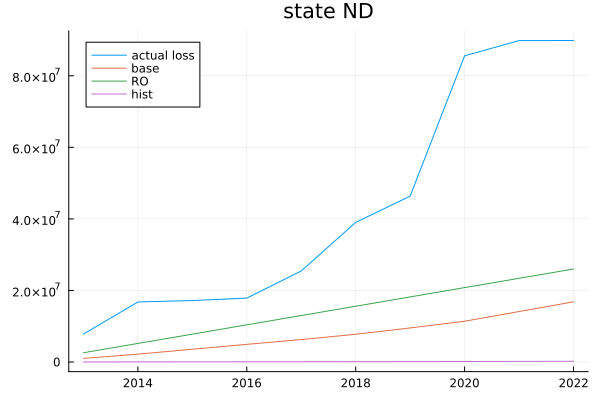

In [175]:
x = time_list[end-9:end] 
i = 7
print(state_list[i])

#crop P_hist to the last 10 years only 
P_hist2 = P_hist[:, end-9:end]

act = cumsum(act_loss[i,:])
base = cumsum(P_base[i,:])
RO= cumsum(P_ro[i,:])
hist = cumsum(P_hist2[i,:])
# LP = cumsum(P_lp[i,:])
plot(x, [act,  base, RO, hist], label=["actual loss" "base" "RO" "hist"], title="state $(state_list[i])")

-1.978122788268e10
-3.0727565577309998e10


In [34]:
#next step: simulations 




In [ ]:
### --- example models ---- 

In [ ]:
function model1(D, A, C)
    
    n_time, n_job  = size(A)
    n_day = size(D)[1]
    
    model = Model(Gurobi.Optimizer)
    set_optimizer_attribute(model, "TimeLimit", 30)
    
    # VARIABLES
    # How many of each shift to use
    @variable(model, x[1:n_day,1:n_job] >=0, Int)
    
    #Resource allocation constraint
    @constraint(model, enough_employees[t=1:n_time, d=1:n_day],
            sum(A[t, j]*x[d,j]  for j = 1:n_job) >= D[d, t])
    
    # OBJECTIVE
    @objective(
        model, Min, sum(C[j] * x[d, j] for d=1:n_day, j=1:n_job)
    )
    
    optimize!(model)
    
    return model, objective_value(model), x
end

In [6]:
df = DataFrame(CSV.File("../../data/nfip_l_bar.csv"))
first(df)



,state,1975,1976,1977,1978,1979,1980,1981,1982
,String3,Float64?,Float64?,Float64?,Float64?,Float64?,Float64,Float64?,Float64?
1,AK,missing,missing,5903.75,11716.5,17612.4,36786.9,15580.5,1048.06


In [19]:
# convert(Matrix, DataFrame(CSV.File("../../data/nfip_l_bar.csv"; header=true)));
Matrix(df)[:,2:49]

57×48 Matrix{Any}:
      missing       missing    5903.75       …  29536.0        93942.4
     0.0            missing   34784.9               2.31784e7      4.05467e5
      missing       missing      77.93              5.61815e6   4168.56
      missing       missing        missing           missing        missing
      missing       missing   50921.6               4.73397e6   2068.31
      missing      0.0            2.36664e5  …      7.12262e6  78977.5
     0.0            missing   12750.8               5.75891e5       missing
      missing   3743.0        32368.1               3.31117e7  36466.8
      missing       missing       0.0               1.23073e5       missing
      missing      0.0        47428.5               7.69196e6   6292.26
 20000.0            missing   41151.4        …      1.96668e7  27720.1
      missing  11003.5        12835.4               9.50741e6      1.2075e5
      missing       missing        missing           missing        missing
     ⋮                  

In [ ]:
#historical 




In [3]:
#compare julia with python https://dataframes.juliadata.org/stable/man/comparisons/ 